In [1]:
import pandas as pd #导入Pandas
import keras
import os
import numpy as np #导入Numpy
import jieba #导入结巴分词
jieba.enable_parallel(32)
import logging
import gensim
import sys
import time
from imp import reload
import matplotlib.pyplot as plt
reload(sys)

Using TensorFlow backend.
Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 2.062 seconds.
Prefix dict has been built succesfully.


<module 'sys' (built-in)>

In [2]:
from keras.preprocessing import sequence
from keras.optimizers import SGD, RMSprop, Adagrad
from keras.models import Sequential
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, GRU
from keras.layers.wrappers import Bidirectional
from keras import backend as K
from keras import metrics
from pickle import dump
from collections import namedtuple

In [3]:
'''
设定日志文件格式
'''
def get_logger(params):
    if not os.path.isdir('log'):
        os.mkdir('log')
    logger = logging.getLogger("my_logger")
    logger.setLevel(logging.DEBUG)
    # 建立一个filehandler来把日志记录在文件里，级别为debug以上
    fh = logging.FileHandler('log/' + params.model_name + "_train.log")
    fh.setLevel(logging.DEBUG)
    # 建立一个streamhandler来把日志打在CMD窗口上，级别为info以上
    ch = logging.StreamHandler()
    ch.setLevel(logging.INFO)
    # 设置日志格式
    formatter = logging.Formatter('[%(levelname)-3s]%(asctime)s %(filename)s[line:%(lineno)d]:%(message)s')
    ch.setFormatter(formatter)
    fh.setFormatter(formatter)
    #将相应的handler添加在logger对象中
    logger.addHandler(ch)
    logger.addHandler(fh)
    return logger

'''
通过gensim加载预训练的word2vec模型
'''
def load_word2vec(model_path):
    try:
        wordvec_model = gensim.models.word2vec.Word2Vec.load(model_path)
        wordvec_weight = wordvec_model.wv.syn0
    except:
        wordvec_model = ''
        wordvec_weight = ''
        print('Pretrained word2vec model not found, use fresh params...')
    return wordvec_model, wordvec_weight
'''
转化情感标记
'''
def trans_emo(emo):
#    trans_dict = dict(zip(['N', 'Y'], range(2)))
    trans_dict = dict(zip(['none', 'disgust', 'like', 'happiness', 'sadness', 'surprise', 'anger', 'fear'], range(8)))
    return trans_dict[emo]
'''
切分训练集和测试集
'''
Train_Set = namedtuple('Train_Set', 'x y xt yt xa ya')
def split_data(train_data, params):
    x = np.array(list(train_data['sent']))[::2] #训练集
    y = np.array(list(train_data['mark']))[::2]
    y = keras.utils.to_categorical(y, params.num_classes)
    xt = np.array(list(train_data['sent']))[1::2] #测试集
    yt = np.array(list(train_data['mark']))[1::2]
    yt = keras.utils.to_categorical(yt, params.num_classes)
    xa = np.array(list(train_data['sent'])) #全集
    ya = np.array(list(train_data['mark']))
    return Train_Set(x, y, xt, yt, xa, ya)

In [4]:
'''
参数设置
'''
class Params():
    def __init__(self, layer_type):
        if layer_type not in ['lstm', 'bilstm', 'gru', 'mutate', 'cnn', 'ConvRnn']:
            raise KeyError
        self.num_classes = 2
        self.maxlen = 20
        self.batch_size = 16
        self.epochs = 10
        self.layer = layer_type
        self.train_data_path = 'train_data/train_data.xlsx'
        self.word2vec_path = '/home/yuangxue/word2vec_from_weixin/word2vec/word2vec_wx'
        self.model_name = 'lstm_try'
        self.embedding_train = False
        self.thread = 16
        self.dict_len = 0
    def get_dict_len(self, dict_len):
        self.dict_len = dict_len

In [5]:
'''
训练数据预处理过程
'''
def preprocess_data(wordvec_model, params, logger):
    if wordvec_model:
        raw_data = pd.read_excel(params.train_data_path)
        logger.info('Data loaded!')
        data = pd.DataFrame({'sent' : raw_data.sentence,
                             'mark' : raw_data.emotion_1 })
        data['mark'] = data['mark'].apply(trans_emo)
        logger.info('emotion_tag transformed!')
        cw = lambda x: list(jieba.cut(str(x))) #定义分词函数
        data['words'] = data['sent'].apply(cw)
        vocab = dict([(k, v.index) for k, v in wordvec_model.wv.vocab.items()])
        word_to_id = lambda word: not (vocab.get(word) is None) and vocab.get(word) or 0
        words_to_ids = lambda words: list(map(word_to_id, words))
        data['sent'] = data['words'].apply(words_to_ids)
        reverse_seq = lambda id_seq: id_seq[::-1]
        concat_seq = lambda a,b: list(np.hstack((a, b)))
        logger.info("Pad sequences (samples x time)...")
        data['sent_rev'] = list(sequence.pad_sequences(data['sent'], maxlen=params.maxlen))
        data['sent_rev'] = data['sent_rev'].apply(reverse_seq)
        data['sent'] = list(sequence.pad_sequences(data['sent'], maxlen=params.maxlen, padding='post', truncating='post'))
        data['sent'] = data['sent'].combine(data['sent_rev'], func=concat_seq)
#        print('2:',data)
    else:
        raw_data = pd.read_excel(params.train_data_path)
        logger.info('Data loaded!')
        data = pd.DataFrame({'sent' : raw_data.sentence,
                             'mark' : raw_data.emotion_1 })
        data['mark'] = data['mark'].apply(trans_emo)
        logger.info('emotion_tag transformed!')
        cw = lambda x: list(jieba.cut(str(x))) #定义分词函数
        data['words'] = data['sent'].apply(cw)
        w = [] #将所有词语整合在一起
        for i in data['words']:
            w.extend(i)
        dict_w = pd.DataFrame(pd.Series(w).value_counts()) #统计词的出现次数
        dict_w['id']=list(range(1,len(dict_w)+1))
        dump(dict_w, open('dict_w.pickle', 'wb'))
        params.get_dict_len(len(dict_w)+1)
        get_sent = lambda x: list(dict_w['id'][x])
        data['sent'] = data['words'].apply(get_sent)
        logger.info("Pad sequences (samples x time)...")
        data['sent'] = list(sequence.pad_sequences(data['sent'], maxlen=params.maxlen, padding='post', truncating='post'))
    return data, params

In [6]:
'''
构建keras模型
'''
def build_model(wordvec_weight, params, logger):
    if wordvec_weight!='':
        word_embedding_layer = Embedding(
            input_dim=wordvec_weight.shape[0],
            output_dim=wordvec_weight.shape[1],
            weights=[wordvec_weight],
            trainable=params.embedding_train)
    else:
        word_embedding_layer = Embedding(params.dict_len+1, 256)
    logger.info('Build model...')
    model = Sequential()
    model.add(word_embedding_layer)
    model.add(Dropout(0.1))
    if params.layer=='lstm':
        model.add(LSTM(128, return_sequences = False))
    elif params.layer=='bilstm':
        model.add(Bidirectional(LSTM(128, return_sequences = False))) 
    elif params.layer=='gru':
        model.add(GRU(128, return_sequences = False))
    elif params.layer=='cnn':
        model.add(Conv1D(256,
                         3,
                         padding='valid',
                         activation='relu',
                         strides=1))
        model.add(GlobalMaxPooling1D())
        # model.add(MaxPooling1D(pool_size = 2))
        # model.add(Flatten())
        model.add(Dropout(0.5))
        model.add(Dense(128))
        model.add(Dropout(0.5))
        model.add(Activation('relu'))
    elif params.layer=='ConvRnn':
        model.add(Conv1D(250,
                         3,
                         padding='valid',
                         activation='relu',
                         strides=1))
        # we use max pooling:
        model.add(MaxPooling1D(pool_size = 2))
        model.add(Dropout(0.3))
        model.add(LSTM(128))
    else: # 采取自定义的模型结构
        model.add(GRU(128, return_sequences = True))
        model.add(Dropout(0.2))
        model.add(GRU(64, return_sequences = False))
    model.add(Dropout(0.5))
    model.add(Dense(params.num_classes))
    model.add(Activation('softmax'))
    sgd = keras.optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=[metrics.mae, metrics.categorical_accuracy])
    return model

In [7]:
params = Params('lstm')
logger = get_logger(params)
logger.info('try loading pretrained word2vec model...')
wordvec_model, wordvec_weight = load_word2vec(params.word2vec_path)
data_all, params = preprocess_data(wordvec_model, params, logger)
train_data = split_data(data_all, params)
model = build_model(wordvec_weight, params, logger)
model.summary()

[INFO]2017-10-16 17:54:51,504 <ipython-input-7-04a6d3601d19>[line:3]:try loading pretrained word2vec model...
[INFO]2017-10-16 17:55:14,617 <ipython-input-5-f66ee8210fd1>[line:7]:Data loaded!
[INFO]2017-10-16 17:55:15,013 <ipython-input-5-f66ee8210fd1>[line:11]:emotion_tag transformed!
[INFO]2017-10-16 18:00:02,804 <ipython-input-5-f66ee8210fd1>[line:20]:Pad sequences (samples x time)...


IndexError: index 2 is out of bounds for axis 1 with size 2

In [9]:
history = model.fit(train_data.x, train_data.y, batch_size=params.batch_size, epochs=params.epochs, validation_data=(train_data.xt, train_data.yt))

Train on 1708 samples, validate on 1708 samples
Epoch 1/50
1708/1708 [==============================] - 8s - loss: 0.6726 - mean_absolute_error: 0.4854 - categorical_accuracy: 0.6183 - val_loss: 0.6626 - val_mean_absolute_error: 0.4796 - val_categorical_accuracy: 0.6475
Epoch 2/50
1708/1708 [==============================] - 6s - loss: 0.6651 - mean_absolute_error: 0.4778 - categorical_accuracy: 0.6335 - val_loss: 0.6569 - val_mean_absolute_error: 0.4732 - val_categorical_accuracy: 0.6470
Epoch 3/50
1708/1708 [==============================] - 6s - loss: 0.6625 - mean_absolute_error: 0.4735 - categorical_accuracy: 0.6352 - val_loss: 0.6542 - val_mean_absolute_error: 0.4689 - val_categorical_accuracy: 0.6470
Epoch 4/50
1708/1708 [==============================] - 7s - loss: 0.6634 - mean_absolute_error: 0.4721 - categorical_accuracy: 0.6347 - val_loss: 0.6531 - val_mean_absolute_error: 0.4669 - val_categorical_accuracy: 0.6470
Epoch 5/50
1708/1708 [==============================] - 6s -

In [10]:
score = model.evaluate(train_data.xt, train_data.yt, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[2])
print(score)

Test loss: 0.645564361395
Test accuracy: 0.646955503443
[0.64556436139470796, 0.45818181967567784, 0.64695550344308594]


dict_keys(['val_categorical_accuracy', 'mean_absolute_error', 'loss', 'val_mean_absolute_error', 'val_loss', 'categorical_accuracy'])


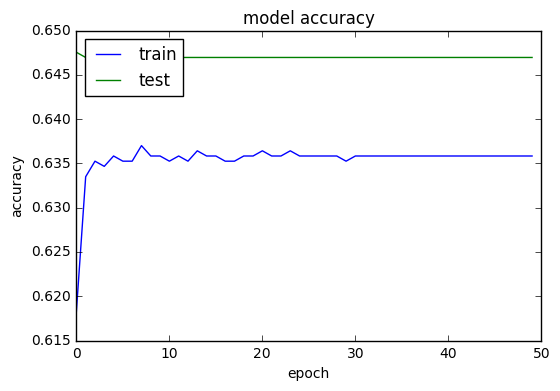

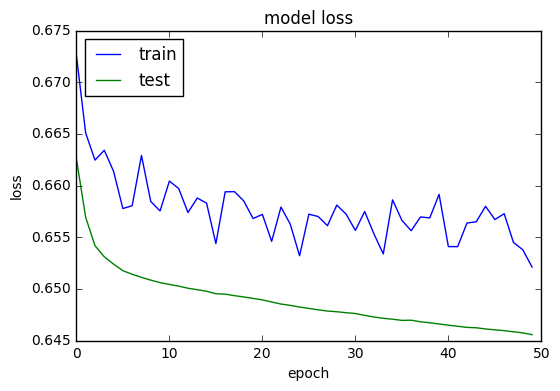

In [11]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()